# Import Library

In [1]:
!pip install linearmodels shap -qq

In [2]:
import pandas as pd
import re
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import shap
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from linearmodels import PooledOLS, PanelOLS, RandomEffects
from statsmodels.compat import lzip
import statsmodels.stats.api as sms
from statsmodels.tsa.stattools import grangercausalitytests

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
data_folder = Path("/content/drive/MyDrive/Airline")

# Global options

In [5]:
pd.options.display.float_format = '{:,.2f}'.format

# Custom Functions

In [6]:
def rmvSpaceFromCol(df):
    newCol = []
    cols = df.columns
    for col in cols:
        newCol.append(re.sub(r'\s+','',col))
    df.columns = newCol
def clean_xlsx(df):
    df = df.reset_index(drop=True)
    df = df.iloc[11:,[1,146,148,159,189]]
    df.columns = ['year','total_fleet_cost','pilot_cost','maintenance_cost','ASM']
    df['total_fleet_cost'] = df['total_fleet_cost'] * 1000
    df['pilot_cost'] = df['pilot_cost'] * 1000
    df['maintenance_cost'] = df['maintenance_cost'] * 1000
    df['CASM_Total'] = df['total_fleet_cost'] / df['ASM']
    df['CASM_Pilot'] = df['pilot_cost'] / df['ASM'] * 100
    df['CASM_Maintenance'] = df['maintenance_cost'] / df['ASM'] * 100
    df.drop(columns=['CASM_Total', 'total_fleet_cost', 'pilot_cost', 'maintenance_cost', 'ASM'], inplace=True)
    return df
def saveModelOutput(model,name="output", x=10, y=6):
    plt.rc('figure', figsize=(x, y))
    plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 10}, fontproperties = 'monospace')
    plt.axis('off')
    plt.tight_layout()
    plt.savefig("/content/drive/MyDrive/Airline/output/"+name+".png")
def saveOutput(out,name="output", x=10, y=6):
    plt.rc('figure', figsize=(x, y))
    plt.text(0.01, 0.05, str(out), {'fontsize': 10}, fontproperties = 'monospace')
    plt.axis('off')
    plt.tight_layout()
    plt.savefig("/content/drive/MyDrive/Airline/output/"+name+".png")
def createOLSData(df, x_vars_list, y_var, scaled = False):
    X = df[x_vars_list]
    if(scaled):
        X = MinMaxScaler().fit_transform(X)
    X = sm.add_constant(X)
    y = df[y_var]
    return X,y

# Import Data

In [7]:
aa_otp = pd.read_csv(data_folder/"AA_OTP.csv")
alaska_otp = pd.read_csv(data_folder/"Alaska_OTP.csv")
delta_otp = pd.read_csv(data_folder/"Delta_OTP.csv")
sw_otp = pd.read_csv(data_folder/"SouthWest_OTP.csv")
united_otp = pd.read_csv(data_folder/"United_OTP.csv")
aa = pd.read_excel(data_folder/"AA.xlsx").transpose()
alaska = pd.read_excel(data_folder/"Alaska.xlsx").transpose()
delta = pd.read_excel(data_folder/"Delta.xlsx").transpose()
sw = pd.read_excel(data_folder/"SouthWest.xlsx").transpose()
united = pd.read_excel(data_folder/"United.xlsx").transpose()

# Preprocessing

In [8]:
rmvSpaceFromCol(aa_otp)
rmvSpaceFromCol(alaska_otp)
rmvSpaceFromCol(delta_otp)
rmvSpaceFromCol(sw_otp)
rmvSpaceFromCol(united_otp)

In [9]:
aa_otp.columns

Index(['year', 'month', 'carrier', 'carrier_name', 'airport', 'airport_name',
       'arr_flights', 'arr_del15', 'carrier_ct', 'weather_ct', 'nas_ct',
       'security_ct', 'late_aircraft_ct', 'arr_cancelled', 'arr_diverted',
       'arr_delay', 'carrier_delay', 'weather_delay', 'nas_delay',
       'security_delay', 'late_aircraft_delay'],
      dtype='object')

In [10]:
aa_otp = aa_otp.iloc[:,[0,6,7,8]]
alaska_otp = alaska_otp.iloc[:,[0,6,7,8]]
delta_otp = delta_otp.iloc[:,[0,6,7,8]]
sw_otp = sw_otp.iloc[:,[0,6,7,8]]
united_otp = united_otp.iloc[:,[0,6,7,8]]

In [11]:
print(aa_otp.isna().sum())
print(alaska_otp.isna().sum())
print(delta_otp.isna().sum())
print(sw_otp.isna().sum())
print(united_otp.isna().sum())

year            0
arr_flights     4
arr_del15      11
carrier_ct      4
dtype: int64
year           0
arr_flights    1
arr_del15      2
carrier_ct     1
dtype: int64
year            0
arr_flights    53
arr_del15      63
carrier_ct     53
dtype: int64
year           0
arr_flights    0
arr_del15      0
carrier_ct     0
dtype: int64
year            0
arr_flights    22
arr_del15      35
carrier_ct     22
dtype: int64


In [12]:
%%capture
aa_otp.fillna(aa_otp.mean(), inplace=True)
alaska_otp.fillna(alaska_otp.mean(), inplace=True)
delta_otp.fillna(delta_otp.mean(), inplace=True)
sw_otp.fillna(sw_otp.mean(), inplace=True)
united_otp.fillna(united_otp.mean(), inplace=True)

In [13]:
aa_otp = aa_otp.groupby('year').sum()
alaska_otp = alaska_otp.groupby('year').sum()
delta_otp = delta_otp.groupby('year').sum()
sw_otp = sw_otp.groupby('year').sum()
united_otp = united_otp.groupby('year').sum()

In [14]:
aa_otp['airline'] = "aa"
alaska_otp['airline'] = "alaska"
delta_otp['airline'] = "delta"
sw_otp['airline'] = "sw"
united_otp['airline'] = "united"

In [15]:
otp = pd.concat([aa_otp, alaska_otp, delta_otp, sw_otp, united_otp])
otp['pc_delay'] = otp['carrier_ct'] / otp['arr_flights']
pc_delay = otp['pc_delay']
otp = otp.drop(columns=['pc_delay'])
otp.insert(loc=2, column='pc_delay', value = pc_delay)
otp.reset_index(inplace=True)

In [16]:
otp = otp.loc[:,['year', 'pc_delay', 'airline', 'arr_flights']]
otp = otp[(otp['year'] >= 2004) & (otp['year'] <= 2020)]

In [17]:
otp

,year,pc_delay,airline,arr_flights
1,2004,0.05,aa,"698,548.00"
2,2005,0.05,aa,"674,225.09"
3,2006,0.05,aa,"643,597.00"
4,2007,0.07,aa,"633,857.00"
5,2008,0.07,aa,"604,885.00"
...,...,...,...,...
89,2016,0.05,united,"545,551.93"
90,2017,0.04,united,"584,481.00"
91,2018,0.04,united,"621,565.00"
92,2019,0.04,united,"626,394.93"


In [18]:
aa = clean_xlsx(aa)
alaska = clean_xlsx(alaska)
delta = clean_xlsx(delta)
sw = clean_xlsx(sw)
united = clean_xlsx(united)

In [19]:
aa['airline'] = "aa"
alaska['airline'] = "alaska"
delta['airline'] = "delta"
sw['airline'] = "sw"
united['airline'] = "united"

In [20]:
cost = pd.concat([aa, alaska, delta, sw, united])

In [21]:
otp = otp.reset_index(drop=True)
cost = cost.reset_index(drop=True)

In [22]:
df = pd.merge(left=cost, right=otp, how="inner", on=['year','airline'])

In [23]:
df

,year,CASM_Pilot,CASM_Maintenance,airline,pc_delay,arr_flights
0,2004,1.15,1.07,aa,0.05,"698,548.00"
1,2005,1.11,1.08,aa,0.05,"674,225.09"
2,2006,1.10,1.14,aa,0.05,"643,597.00"
3,2007,1.11,1.15,aa,0.07,"633,857.00"
4,2008,1.12,1.34,aa,0.07,"604,885.00"
...,...,...,...,...,...,...
80,2016,1.51,1.21,united,0.05,"545,551.93"
81,2017,1.54,1.27,united,0.04,"584,481.00"
82,2018,1.62,1.20,united,0.04,"621,565.00"
83,2019,1.66,1.15,united,0.04,"626,394.93"


In [24]:
for var in df.columns:
    if df[var].dtype == 'O' and var != 'airline' and var != 'year':
        df[var] = df[var].astype(float)

In [25]:
df['pc_delay_change'] = df.groupby(['airline'])['pc_delay'].pct_change()
df['CASM_Pilot_change'] = df.groupby(['airline'])['CASM_Pilot'].pct_change()
df['CASM_Maintenance_change'] = df.groupby(['airline'])['CASM_Maintenance'].pct_change()

In [26]:
df['CASM_Pilot2'] = df['CASM_Pilot']**2
df['CASM_Maintenance2'] = df['CASM_Maintenance']**2
df['CASM_Pilot_CASM_Maintenance'] = df['CASM_Pilot'] * df['CASM_Maintenance']

In [27]:
df = df[['airline', 'year', 'CASM_Pilot', 'CASM_Maintenance', 'CASM_Pilot2', 'CASM_Maintenance2', 'CASM_Pilot_CASM_Maintenance', 'arr_flights' , 'pc_delay', 'CASM_Pilot_change', 'CASM_Maintenance_change', 'pc_delay_change']]

In [28]:
df_covid = df[(df['year'] >= 2006) & (df['year'] <= 2020)]
df_pre_covid = df[(df['year'] >= 2005) & (df['year'] <= 2019)]
# Creating panel data
panel_covid = df_covid.set_index(["airline","year"])
panel_pre_covid = df_pre_covid.set_index(["airline","year"])

# EDA

In [29]:
panel_covid.describe().T

,count,mean,std,min,25%,50%,75%,max
CASM_Pilot,75.00,1.44,0.58,0.77,1.14,1.29,1.61,3.62
CASM_Maintenance,75.00,1.20,0.30,0.69,1.03,1.15,1.34,2.79
CASM_Pilot2,75.00,2.41,2.46,0.60,1.29,1.65,2.59,13.08
CASM_Maintenance2,75.00,1.52,0.92,0.48,1.05,1.33,1.78,7.76
CASM_Pilot_CASM_Maintenance,75.00,1.80,1.25,0.67,1.18,1.55,1.86,9.51
arr_flights,75.00,"648,120.16","361,093.46","136,950.00","403,018.57","569,806.00","924,889.70","1,363,946.00"
pc_delay,75.00,0.05,0.01,0.02,0.04,0.05,0.06,0.08
CASM_Pilot_change,75.00,0.09,0.22,-0.24,0.00,0.04,0.10,1.18
CASM_Maintenance_change,75.00,0.05,0.17,-0.24,-0.03,0.02,0.08,0.89
pc_delay_change,75.00,-0.02,0.21,-0.62,-0.15,-0.01,0.08,0.67


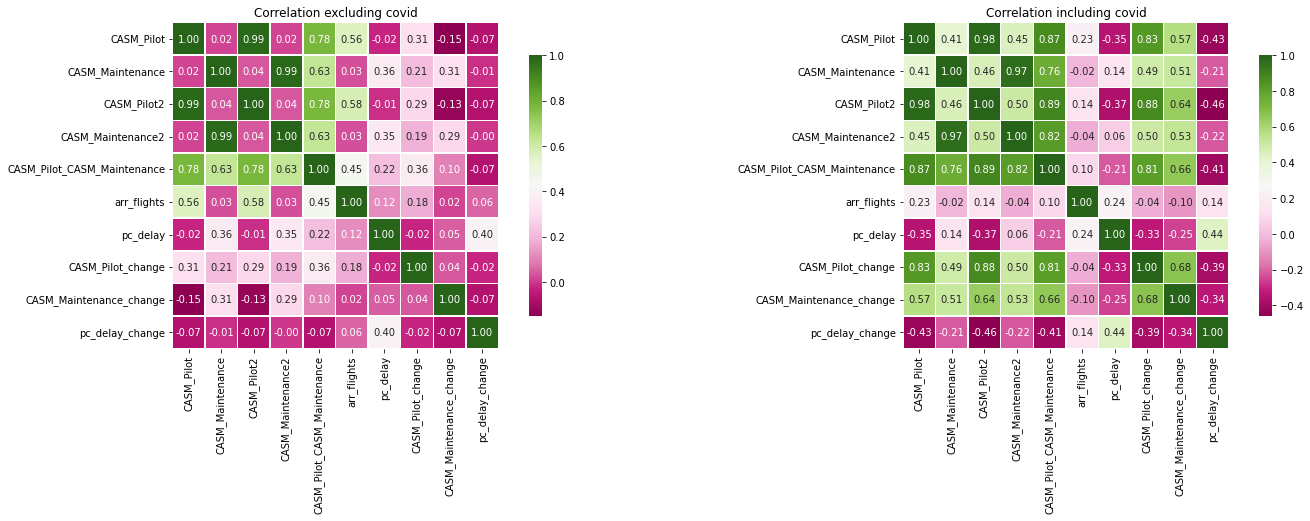

In [30]:
corrmat = df_covid.drop(columns=['year','airline']).corr().round(2)
corrmat_pre = df_pre_covid.drop(columns=['year','airline']).corr().round(2)
plt.figure(figsize=(24, 6))
plt.subplot(1,2,1)
sns.heatmap(corrmat_pre,annot=True, square=True, fmt='.2f', cbar_kws={"shrink": .80}, linewidths=.5, cmap='PiYG')
plt.title("Correlation excluding covid")
plt.subplot(1,2,2)
sns.heatmap(corrmat,annot=True, square=True, fmt='.2f', cbar_kws={"shrink": .80}, linewidths=.5, cmap='PiYG')
plt.title("Correlation including covid")
plt.show()

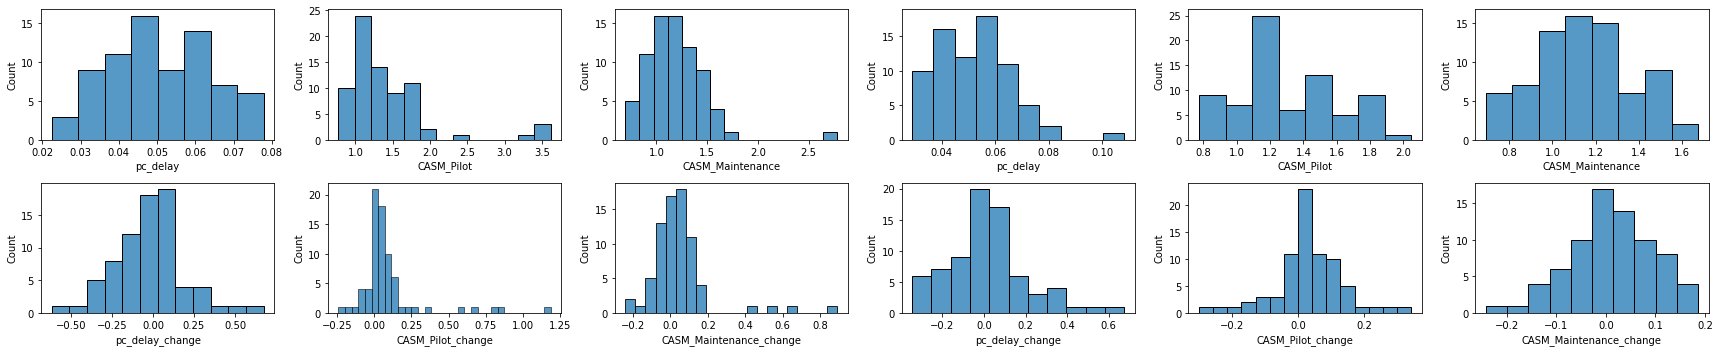

In [31]:
plt.figure(figsize=(24,5))
plt.subplot(2,6,1)
sns.histplot(data=df_covid, x="pc_delay")
plt.subplot(2,6,2)
sns.histplot(data=df_covid, x="CASM_Pilot")
plt.subplot(2,6,3)
sns.histplot(data=df_covid, x="CASM_Maintenance")
plt.subplot(2,6,4)
sns.histplot(data=df_pre_covid, x="pc_delay")
plt.subplot(2,6,5)
sns.histplot(data=df_pre_covid, x="CASM_Pilot")
plt.subplot(2,6,6)
sns.histplot(data=df_pre_covid, x="CASM_Maintenance")
# plt.figure(figsize=(24,10))
plt.subplot(2,6,7)
sns.histplot(data=df_covid, x="pc_delay_change")
plt.subplot(2,6,8)
sns.histplot(data=df_covid, x="CASM_Pilot_change")
plt.subplot(2,6,9)
sns.histplot(data=df_covid, x="CASM_Maintenance_change")
plt.subplot(2,6,10)
sns.histplot(data=df_pre_covid, x="pc_delay_change")
plt.subplot(2,6,11)
sns.histplot(data=df_pre_covid, x="CASM_Pilot_change")
plt.subplot(2,6,12)
sns.histplot(data=df_pre_covid, x="CASM_Maintenance_change")
plt.tight_layout()

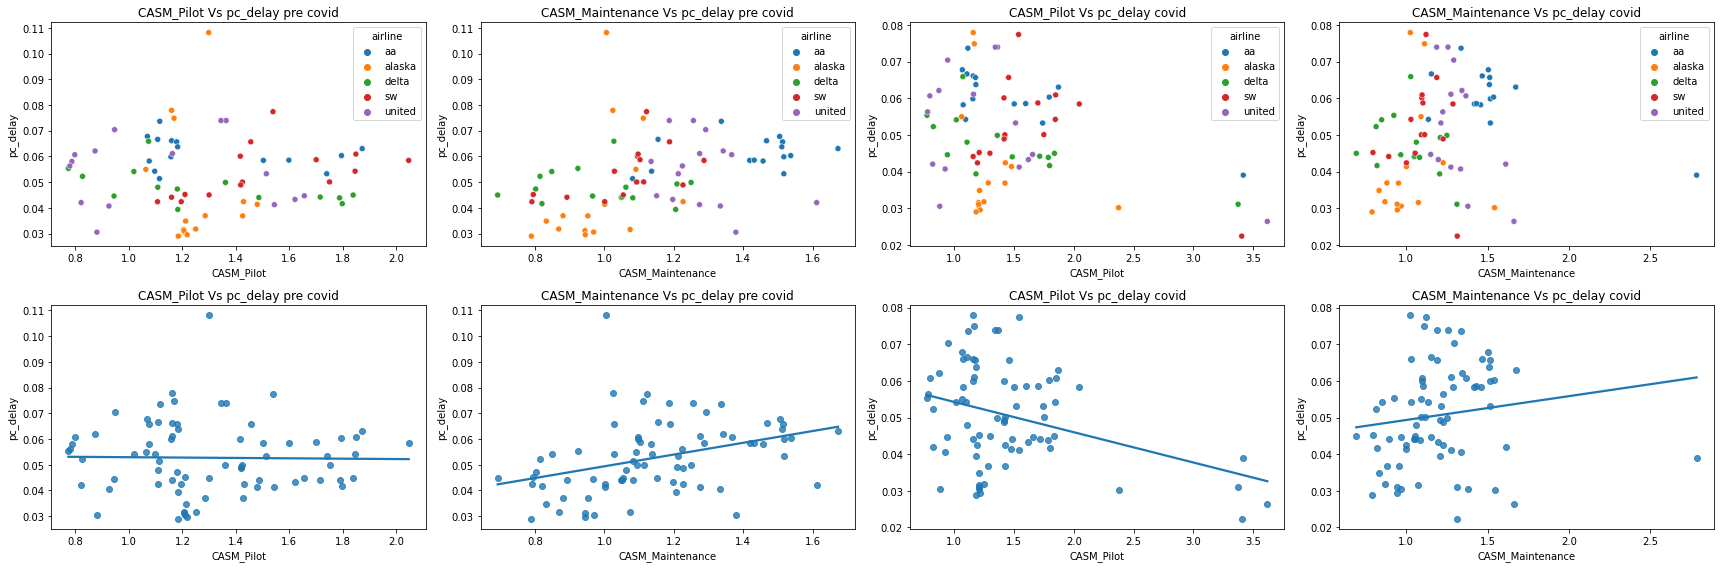

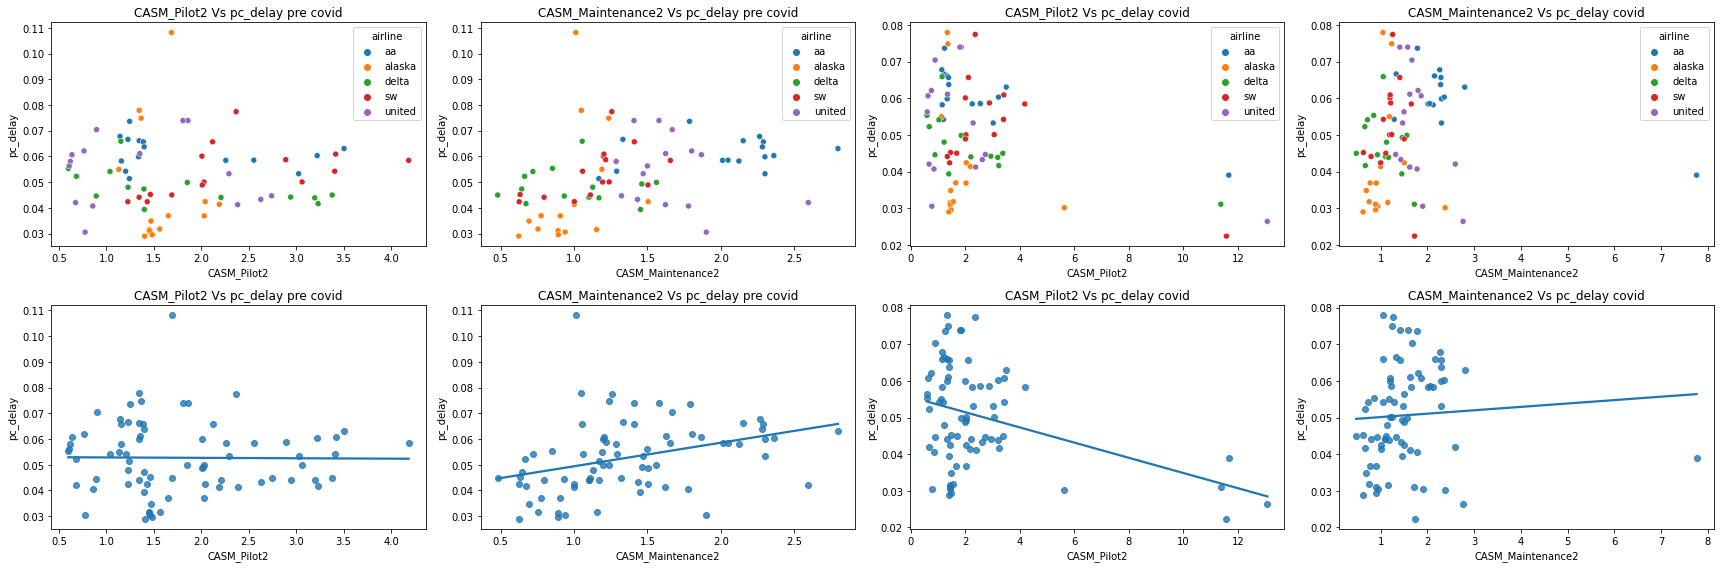

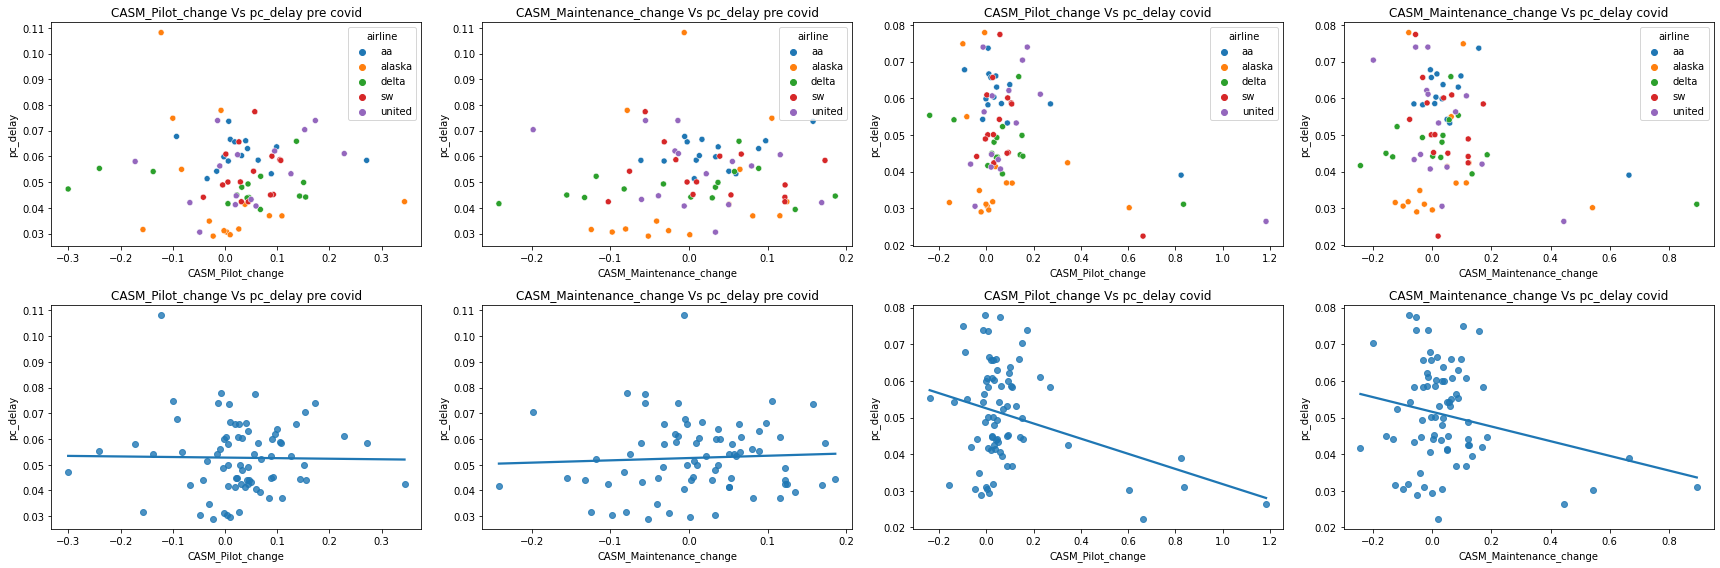

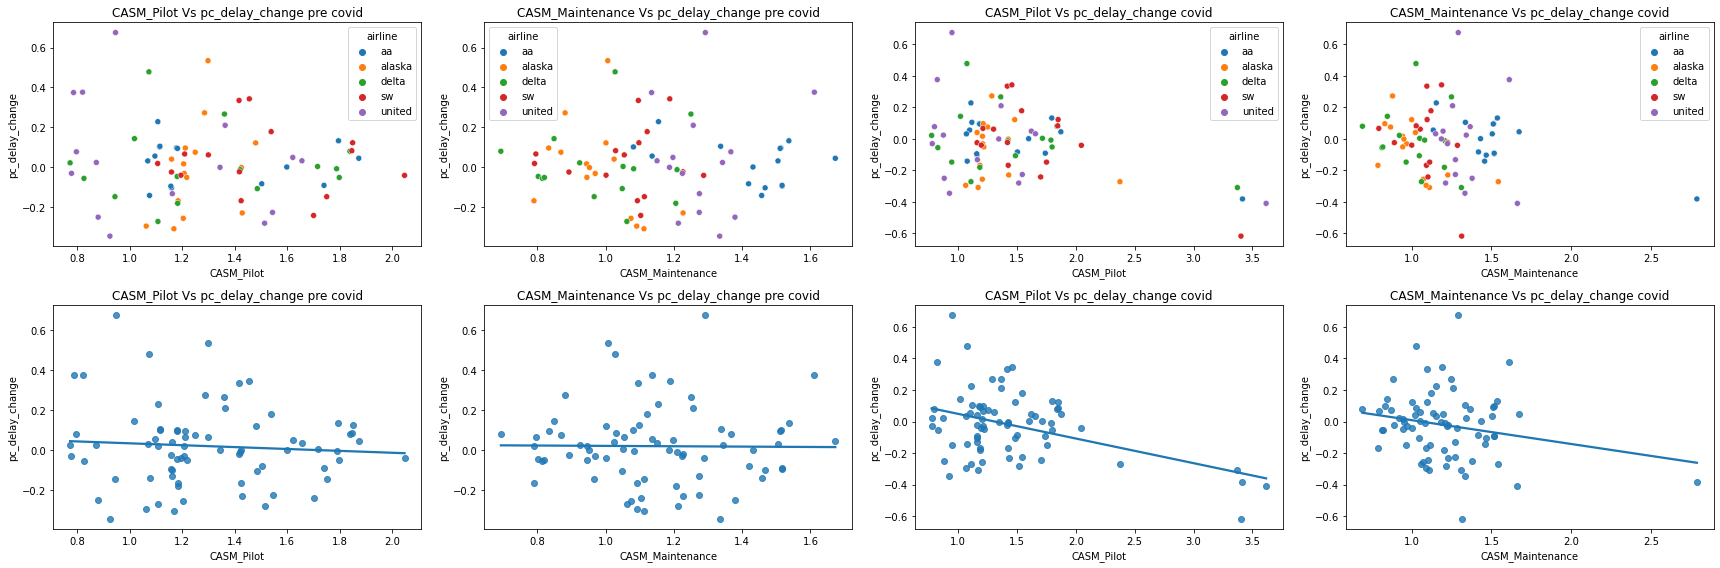

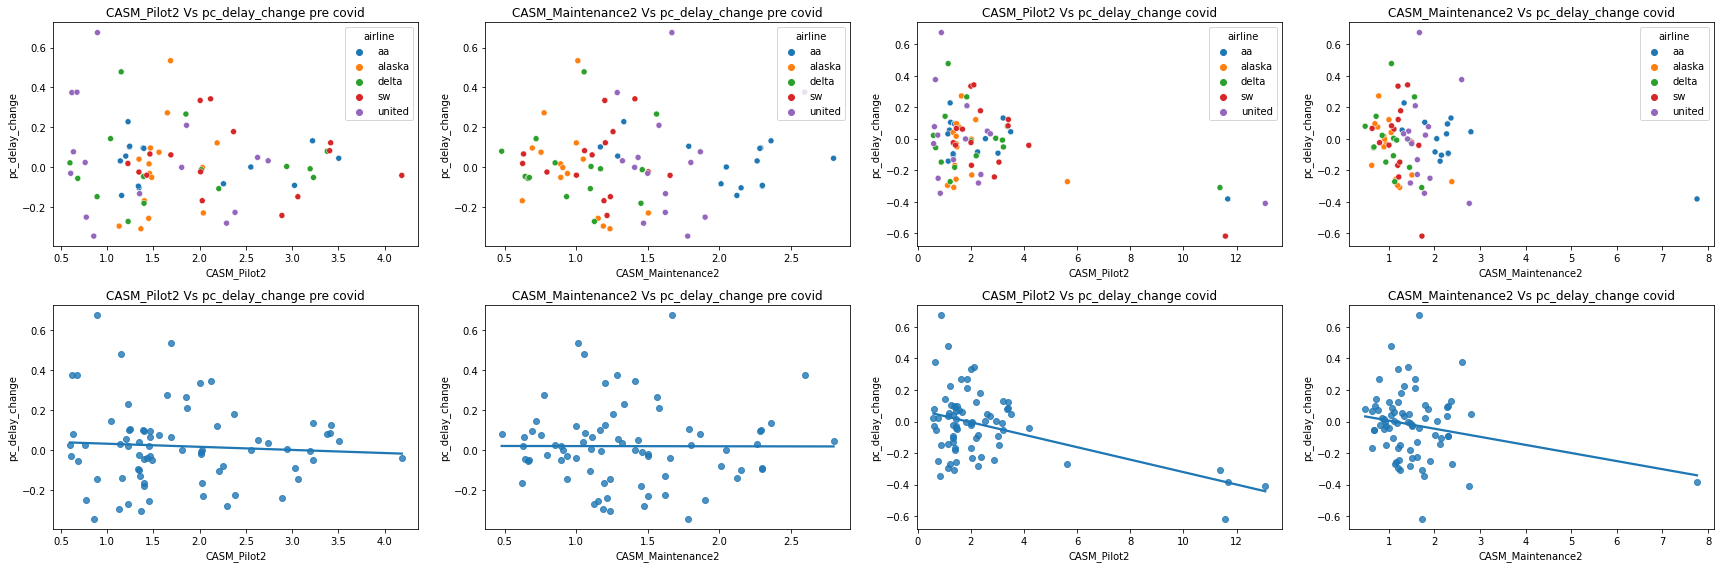

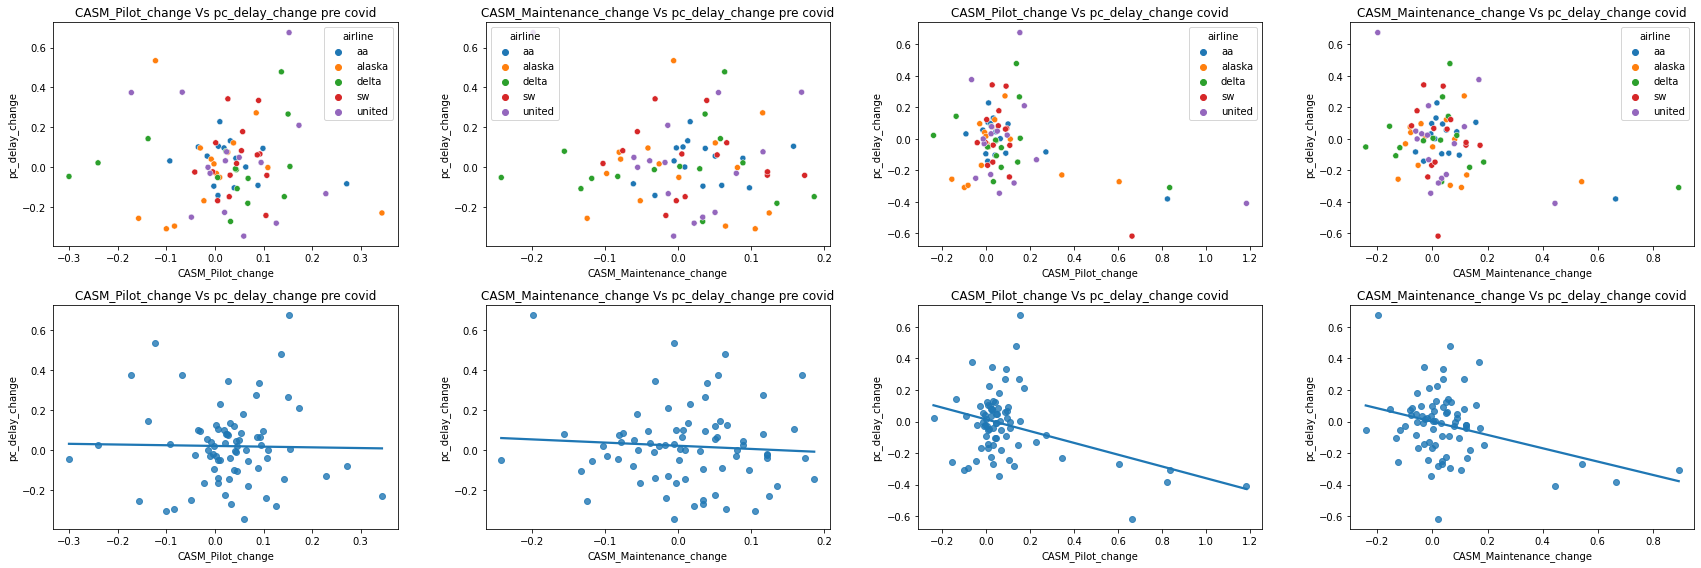

In [32]:
def plots(x1, x2, y):
    plt.figure(figsize=(24,8))
    plt.subplot(2,4,1)
    sns.scatterplot(x=x1, y=y, hue= "airline", data=df_pre_covid)
    plt.title(x1 + " Vs " + y + " pre covid")
    plt.subplot(2,4,2)
    sns.scatterplot(x=x2, y=y, hue= "airline", data=df_pre_covid)
    plt.title(x2 + " Vs " + y + " pre covid")
    plt.subplot(2,4,3)
    sns.scatterplot(x=x1, y=y, hue= "airline", data=df_covid)
    plt.title(x1 + " Vs " + y + " covid")
    plt.subplot(2,4,4)
    sns.scatterplot(x=x2, y=y, hue= "airline", data=df_covid)
    plt.title(x2 + " Vs " + y + " covid")
    plt.subplot(2,4,5)
    sns.regplot(x=x1, y=y, data=df_pre_covid, ci=None)
    plt.title(x1 + " Vs " + y + " pre covid")
    plt.subplot(2,4,6)
    sns.regplot(x=x2, y=y, data=df_pre_covid, ci=None)
    plt.title(x2 + " Vs " + y + " pre covid")
    plt.subplot(2,4,7)
    sns.regplot(x=x1, y=y, data=df_covid, ci=None)
    plt.title(x1 + " Vs " + y + " covid")
    plt.subplot(2,4,8)
    sns.regplot(x=x2, y=y, data=df_covid, ci=None)
    plt.title(x2 + " Vs " + y + " covid")
    plt.tight_layout()
    plt.show()

plots("CASM_Pilot", "CASM_Maintenance", "pc_delay")
plots("CASM_Pilot2", "CASM_Maintenance2", "pc_delay")
plots("CASM_Pilot_change", "CASM_Maintenance_change", "pc_delay")
plots("CASM_Pilot", "CASM_Maintenance", "pc_delay_change")
plots("CASM_Pilot2", "CASM_Maintenance2", "pc_delay_change")
plots("CASM_Pilot_change", "CASM_Maintenance_change", "pc_delay_change")

In [33]:
df_covid.head(3)

,airline,year,CASM_Pilot,CASM_Maintenance,CASM_Pilot2,CASM_Maintenance2,CASM_Pilot_CASM_Maintenance,arr_flights,pc_delay,CASM_Pilot_change,CASM_Maintenance_change,pc_delay_change
2,aa,2006,1.10,1.14,1.20,1.29,1.25,"643,597.00",0.05,-0.02,0.05,0.06
3,aa,2007,1.11,1.15,1.23,1.33,1.28,"633,857.00",0.07,0.01,0.02,0.23
4,aa,2008,1.12,1.34,1.24,1.79,1.49,"604,885.00",0.07,0.01,0.16,0.11


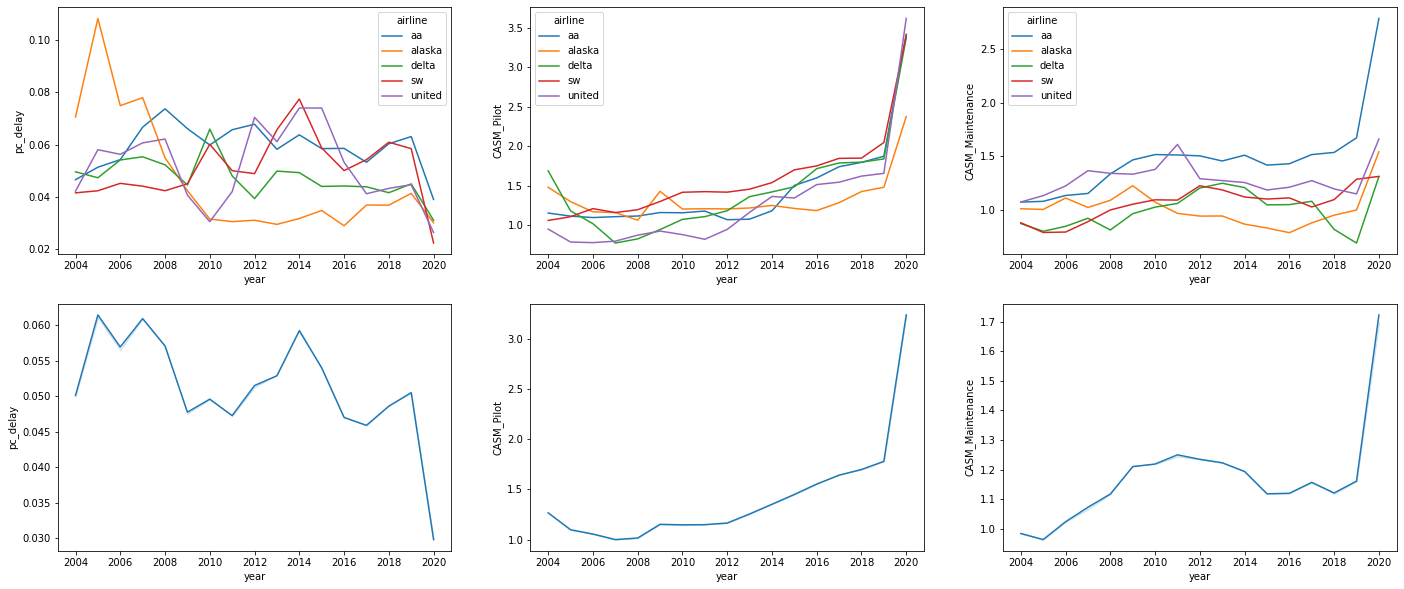

In [34]:
plt.figure(figsize=(24,10))
plt.subplot(2,3,1)
sns.lineplot(x = "year", y = "pc_delay", hue="airline", data=df, ci=0)
plt.subplot(2,3,2)
sns.lineplot(x = "year", y = "CASM_Pilot", hue="airline", data=df, ci=0)
plt.subplot(2,3,3)
sns.lineplot(x = "year", y = "CASM_Maintenance", hue="airline", data=df, ci=0)
plt.subplot(2,3,4)
sns.lineplot(x = "year", y = "pc_delay", data=df, ci=0)
plt.subplot(2,3,5)
sns.lineplot(x = "year", y = "CASM_Pilot", data=df, ci=0)
plt.subplot(2,3,6)
sns.lineplot(x = "year", y = "CASM_Maintenance", data=df, ci=0)
# plt.subplot(2,3,4)
# sns.lineplot(x = "year", y = "pc_delay_change", hue="airline", data=df, ci=0)
# plt.subplot(2,3,5)
# sns.lineplot(x = "year", y = "CASM_Pilot_change", hue="airline", data=df, ci=0)
# plt.subplot(2,3,6)
# sns.lineplot(x = "year", y = "CASM_Maintenance_change", hue="airline", data=df, ci=0)
plt.show()

In [35]:
temp = df

In [36]:
temp['pc_delay'] = -1 * temp['pc_delay']

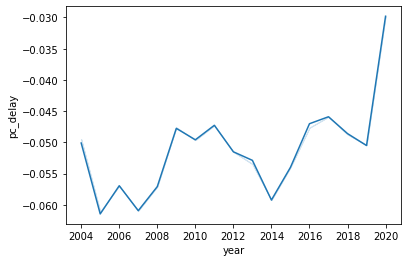

In [37]:
sns.lineplot(x = "year", y = "pc_delay", data=temp, ci=0)

# Granger-Causality Test

Null Hypothesis (H0): Variable x does not Granger-cause Variable y

Alternative Hypothesis (HA): Variable x Granger-causes Variable y

In [38]:
# Testing if maintenence causes delays for the entire data
# Reject null hypothesis as p-value is less than 0.05
grangercausalitytests(df[['CASM_Maintenance', 'pc_delay']], maxlag=1)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.5770  , p=0.0044  , df_denom=81, df_num=1
ssr based chi2 test:   chi2=8.8946  , p=0.0029  , df=1
likelihood ratio test: chi2=8.4545  , p=0.0036  , df=1
parameter F test:         F=8.5770  , p=0.0044  , df_denom=81, df_num=1


{1: ({'lrtest': (8.45451629897076, 0.0036413807908656356, 1),
   'params_ftest': (8.576961269732474, 0.004419636949743689, 81.0, 1.0),
   'ssr_chi2test': (8.894626501944797, 0.0028601110399596027, 1),
   'ssr_ftest': (8.576961269732482, 0.004419636949743689, 81.0, 1)},
   array([[0., 1., 0.]])])}

In [39]:
# Testing if pilots cause delays for the entire data
# Do not reject null hypothesis as p-value is greater than 0.05
grangercausalitytests(df[['CASM_Pilot', 'pc_delay']], maxlag=[1])


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2924  , p=0.2590  , df_denom=81, df_num=1
ssr based chi2 test:   chi2=1.3403  , p=0.2470  , df=1
likelihood ratio test: chi2=1.3297  , p=0.2489  , df=1
parameter F test:         F=1.2924  , p=0.2590  , df_denom=81, df_num=1


{1: ({'lrtest': (1.3297054537932382, 0.24885762461234412, 1),
   'params_ftest': (1.2924183646484873, 0.25895480793586806, 81.0, 1.0),
   'ssr_chi2test': (1.3402857114873192, 0.24698358870831089, 1),
   'ssr_ftest': (1.2924183646484864, 0.25895480793586806, 81.0, 1)},
   array([[0., 1., 0.]])])}

# Outliers in the dataset

In [40]:
df_out = df[['CASM_Pilot', 'CASM_Maintenance', 'CASM_Pilot2', 'CASM_Maintenance2', 'pc_delay', 'CASM_Pilot_change', 'CASM_Maintenance_change', 'pc_delay_change']]

In [41]:
for column in df_out:
  z = np.abs(stats.zscore(df_out[column]))
  print(np.where(z > 3))

(array([16, 50, 67, 84]),)
(array([16]),)
(array([16, 50, 67, 84]),)
(array([16]),)
(array([18]),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)


# Export Data

In [42]:
df.to_csv(data_folder/"df_airline.csv", index=False)
df_covid.to_csv(data_folder/"df_covid.csv", index=False)
df_pre_covid.to_csv(data_folder/"df_pre_covid.csv", index=False)

# OLS Model

## Model 1

In [ ]:
print("OLS 1 - Covid Data")
data = createOLSData(df_covid, ['CASM_Pilot', 'CASM_Maintenance'], 'pc_delay')
ols1 = sm.OLS(data[1], data[0]).fit()
print(ols1.summary())
print("OLS 2 - Pre Covid Data")
data = createOLSData(df_pre_covid, ['CASM_Pilot', 'CASM_Maintenance'], 'pc_delay')
ols2 = sm.OLS(data[1], data[0]).fit()
print(ols2.summary())
print("OLS 3 - Covid Data")
data = createOLSData(df_covid, ['CASM_Pilot', 'CASM_Maintenance','CASM_Pilot2', 'CASM_Maintenance2'], 'pc_delay')
ols3 = sm.OLS(data[1], data[0]).fit()
print(ols3.summary())
print("OLS 4 - Pre Covid Data")
data = createOLSData(df_pre_covid, ['CASM_Pilot', 'CASM_Maintenance','CASM_Pilot2', 'CASM_Maintenance2'], 'pc_delay')
ols4 = sm.OLS(data[1], data[0]).fit()
print(ols4.summary())

OLS 1 - Covid Data
                            OLS Regression Results                            
Dep. Variable:               pc_delay   R-squared:                       0.358
Model:                            OLS   Adj. R-squared:                  0.341
Method:                 Least Squares   F-statistic:                     20.11
Date:                Fri, 29 Apr 2022   Prob (F-statistic):           1.15e-07
Time:                        14:26:25   Log-Likelihood:                 141.19
No. Observations:                  75   AIC:                            -276.4
Df Residuals:                      72   BIC:                            -269.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                

## Breusch Pagan Test for Heteroscedasticity<br>
H0 - Homoscedasticity present<br>
H1 = Heteroscedasticity present

In [ ]:
names = ['Lagrange multiplier statistic', 'p-value',
        'f-value', 'f p-value']
test = sms.het_breuschpagan(ols1.resid, ols1.model.exog)
print(lzip(names, test))
names = ['Lagrange multiplier statistic', 'p-value',
        'f-value', 'f p-value']
test = sms.het_breuschpagan(ols2.resid, ols2.model.exog)
print(lzip(names, test))
names = ['Lagrange multiplier statistic', 'p-value',
        'f-value', 'f p-value']
test = sms.het_breuschpagan(ols3.resid, ols3.model.exog)
print(lzip(names, test))
names = ['Lagrange multiplier statistic', 'p-value',
        'f-value', 'f p-value']
test = sms.het_breuschpagan(ols4.resid, ols4.model.exog)
print(lzip(names, test))

[('Lagrange multiplier statistic', 3.264812940061326), ('p-value', 0.19545864234752683), ('f-value', 1.6384325553372039), ('f p-value', 0.20144429969254607)]
[('Lagrange multiplier statistic', 3.513090270930905), ('p-value', 0.172640283476297), ('f-value', 1.7691525655932052), ('f p-value', 0.17780720971263325)]
[('Lagrange multiplier statistic', 5.659029824670537), ('p-value', 0.22610025499377018), ('f-value', 1.4282035812497031), ('f p-value', 0.23372716813331418)]
[('Lagrange multiplier statistic', 5.404517908809103), ('p-value', 0.24825079023646643), ('f-value', 1.3589828040882368), ('f p-value', 0.2570367130343368)]


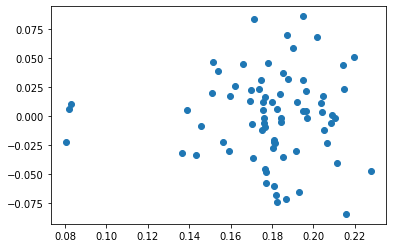

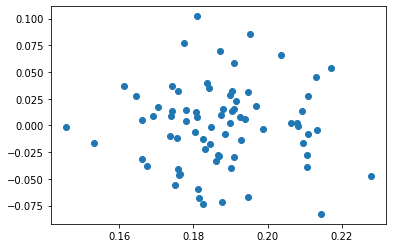

In [ ]:
plt.scatter(ols1.fittedvalues, ols1.resid)
plt.show()
plt.scatter(ols2.fittedvalues, ols2.resid)
plt.show()

# Panel OLS Model

### Model 1

In [ ]:
data = createOLSData(panel_covid, ['CASM_Pilot', 'CASM_Maintenance'], 'pc_delay')
ols = PanelOLS(data[1], data[0], entity_effects=False).fit()
print(ols)
data = createOLSData(panel_covid, ['CASM_Pilot', 'CASM_Maintenance','CASM_Pilot2', 'CASM_Maintenance2'], 'pc_delay')
ols = PanelOLS(data[1], data[0], entity_effects=False).fit()
print(ols)

                          PanelOLS Estimation Summary                           
Dep. Variable:               pc_delay   R-squared:                        0.3584
Estimator:                   PanelOLS   R-squared (Between):              0.3569
No. Observations:                  75   R-squared (Within):               0.3587
Date:                Fri, Apr 29 2022   R-squared (Overall):              0.3584
Time:                        14:26:26   Log-likelihood                    141.19
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      20.113
Entities:                           5   P-value                           0.0000
Avg Obs:                       15.000   Distribution:                    F(2,72)
Min Obs:                       15.000                                           
Max Obs:                       15.000   F-statistic (robust):             20.113
                            

# Fixed-Effects (FE) Model

### Model 1

In [ ]:
data = createOLSData(panel_covid, ['CASM_Pilot', 'CASM_Maintenance'], 'pc_delay')
ols = PanelOLS(data[1], data[0], entity_effects=True).fit()
print(ols)
data = createOLSData(panel_pre_covid, ['CASM_Pilot', 'CASM_Maintenance'], 'pc_delay')
ols = PanelOLS(data[1], data[0], entity_effects=True).fit()
print(ols)
data = createOLSData(panel_covid, ['CASM_Pilot', 'CASM_Maintenance','CASM_Pilot2', 'CASM_Maintenance2'], 'pc_delay')
ols = PanelOLS(data[1], data[0], entity_effects=True).fit()
print(ols)
data = createOLSData(panel_pre_covid, ['CASM_Pilot', 'CASM_Maintenance','CASM_Pilot2', 'CASM_Maintenance2'], 'pc_delay')
ols = PanelOLS(data[1], data[0], entity_effects=True).fit()
print(ols)
data = createOLSData(panel_covid, ['CASM_Pilot_change', 'CASM_Maintenance_change'], 'pc_delay_change')
ols = PanelOLS(data[1], data[0], entity_effects=True).fit()
print(ols)
data = createOLSData(panel_pre_covid, ['CASM_Pilot_change', 'CASM_Maintenance_change'], 'pc_delay_change')
ols = PanelOLS(data[1], data[0], entity_effects=True).fit()
print(ols)

                          PanelOLS Estimation Summary                           
Dep. Variable:               pc_delay   R-squared:                        0.4106
Estimator:                   PanelOLS   R-squared (Between):             -0.5031
No. Observations:                  75   R-squared (Within):               0.4106
Date:                Fri, Apr 29 2022   R-squared (Overall):              0.2595
Time:                        14:26:26   Log-likelihood                    151.14
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      23.681
Entities:                           5   P-value                           0.0000
Avg Obs:                       15.000   Distribution:                    F(2,68)
Min Obs:                       15.000                                           
Max Obs:                       15.000   F-statistic (robust):             23.681
                            

# Random-Effects (RE) Model

### Model 1

In [ ]:
data = createOLSData(panel_covid, ['CASM_Pilot', 'CASM_Maintenance'], 'pc_delay')
ols = RandomEffects(data[1], data[0],).fit()
print(ols)
# data = createOLSData(panel_covid, ['CASM_Pilot', 'CASM_Maintenance','CASM_Pilot2', 'CASM_Maintenance2'], 'pc_delay')
# ols = RandomEffects(data[1], data[0],).fit()
# print(ols)
data = createOLSData(panel_covid, ['CASM_Pilot_change', 'CASM_Maintenance_change'], 'pc_delay_change')
ols = RandomEffects(data[1], data[0],).fit()
print(ols)

                        RandomEffects Estimation Summary                        
Dep. Variable:               pc_delay   R-squared:                        0.3584
Estimator:              RandomEffects   R-squared (Between):              0.3569
No. Observations:                  75   R-squared (Within):               0.3587
Date:                Fri, Apr 29 2022   R-squared (Overall):              0.3584
Time:                        14:26:26   Log-likelihood                    141.19
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      20.113
Entities:                           5   P-value                           0.0000
Avg Obs:                       15.000   Distribution:                    F(2,72)
Min Obs:                       15.000                                           
Max Obs:                       15.000   F-statistic (robust):             20.113
                            